<center><h1>US Wind Power Production 2001 - 2023 Analysis</h1></center>

By: Elijah Taber

This dataset is primarily centered around wind renewable energy, consisting of annual data from 2001 to early 2023 on both total wind energy production and "other" renewable energy sources. Consequently, our analysis will predominantly examine wind energy production across various states, presuming comprehensive coverage without significant data gaps. While information from the "other" renewable energy categories allows for a comparison with wind energy output, the unspecified nature of these sources limits our ability to draw concrete conclusions about their impact or significance. Given this ambiguity, it is advisable to focus our analytical efforts on wind energy, avoiding potentially misleading interpretations of the less-defined "other" renewable energy data.

# Importing Relavent Libraries

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np
import re
import warnings
import os
import datetime

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px

# Machine Learning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)

# Rather than transform the date column manually, Pandas will do it automatically with the parse_dates parameter
df = pd.read_csv(
    "C:\\Users\\Elijah Taber\\OneDrive\\Documents\\Projects\\US Wind Power Production with ARIMA\\Data\\wind-power-production-us.csv", 
    index_col = "date", 
    parse_dates = True
)

df.head().style.format(precision=1).set_properties(**{'border': '1.5px solid black'}).background_gradient(cmap='binary')

,other_united_states,other_new_england,other_connecticut,other_maine,other_massachusetts,other_new_hampshire,other_rhode_island,other_vermont,other_middle_atlantic,other_new_jersey,other_new_york,other_pennsylvania,other_east_north_central,other_illinois,other_indiana,other_michigan,other_ohio,other_wisconsin,other_west_north_central,other_iowa,other_kansas,other_minnesota,other_missouri,other_nebraska,other_north_dakota,other_south_dakota,other_south_atlantic,other_delaware,other_district_of_columbia,other_florida,other_georgia,other_maryland,other_north_carolina,other_south_carolina,other_virginia,other_west_virginia,other_east_south_central,other_alabama,other_kentucky,other_mississippi,other_tennessee,other_west_south_central,other_arkansas,other_louisiana,other_oklahoma,other_texas,other_mountain,other_arizona,other_colorado,other_idaho,other_montana,other_nevada,other_new_mexico,other_utah,other_wyoming,other_pacific_contiguous,other_california,other_oregon,other_washington,other_pacific_noncontiguous,other_alaska,other_hawaii,wind,wind_united_states,wind_new_england,wind_connecticut,wind_maine,wind_massachusetts,wind_new_hampshire,wind_rhode_island,wind_vermont,wind_middle_atlantic,wind_new_jersey,wind_new_york,wind_pennsylvania,wind_east_north_central,wind_illinois,wind_indiana,wind_michigan,wind_ohio,wind_wisconsin,wind_west_north_central,wind_iowa,wind_kansas,wind_minnesota,wind_missouri,wind_nebraska,wind_north_dakota,wind_south_dakota,wind_south_atlantic,wind_delaware,wind_district_of_columbia,wind_florida,wind_georgia,wind_maryland,wind_north_carolina,wind_south_carolina,wind_virginia,wind_west_virginia,wind_east_south_central,wind_alabama,wind_kentucky,wind_mississippi,wind_tennessee,wind_west_south_central,wind_arkansas,wind_louisiana,wind_oklahoma,wind_texas,wind_mountain,wind_arizona,wind_colorado,wind_idaho,wind_montana,wind_nevada,wind_new_mexico,wind_utah,wind_wyoming,wind_pacific_contiguous,wind_california,wind_oregon,wind_washington,wind_pacific_noncontiguous,wind_alaska,wind_hawaii
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,6025,678,75,348,113,91,10,42,371,66,154,151,402,59,9,195,42,97,234,53,--,178,1,2,1,0,1056,--,--,335,261,27,157,115,161,1,591,401,1,115,75,558,137,226,20,176,209,0,9,43,5,109,2,14,26,1883,1717,51,114,42,0,42,nan,389,1,--,--,--,--,--,1,3,--,2,1,4,--,--,--,--,4,130,44,--,86,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,84,--,--,--,84,30,--,4,--,--,--,--,--,26,137,133,3,--,0,0,0
2001-02-01 00:00:00,5310,599,77,293,103,83,9,35,338,59,141,138,348,48,9,169,34,87,196,41,--,152,1,2,1,0,913,--,--,298,256,27,132,64,134,2,482,332,1,91,59,572,126,203,19,223,184,0,8,39,6,94,1,13,23,1642,1505,40,97,36,0,36,nan,431,1,--,--,--,--,--,1,2,--,1,1,4,--,--,--,--,4,106,33,--,73,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,142,--,--,--,142,25,--,2,--,--,--,--,--,23,151,148,3,--,0,0,0
2001-03-01 00:00:00,5795,660,96,327,101,93,9,33,381,73,156,153,387,54,9,193,40,91,205,45,--,157,1,2,1,0,926,--,--,310,256,30,132,64,132,2,489,355,1,79,54,526,119,222,17,169,207,1,8,49,6,106,2,14,22,1984,1788,87,109,30,0,30,nan,532,1,--,--,--,--,--,1,3,--,2,1,3,--,--,--,--,3,105,38,--,67,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,88,--,--,--,88,24,--,2,--,--,--,--,--,22,308,300,8,--,0,0,0
2001-04-01 00:00:00,5827,593,92,277,106,81,9,27,361,66,141,154,372,50,8,196,36,82,244,62,--,179,1,2,1,0,969,--,--,321,258,29,161,74,123,3,498,347,1,85,65,577,136,234,15,192,186,1,8,46,6,98,2,13,13,1982,1797,75,110,44,0,43,nan,685,1,--,--,--,--,--,1,3,--,2,1,5,--,--,--,--,5,146,54,--,91,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,115,--,--,--,115,16,--,3,--,--,--,--,--,13,399,393,6,--,0,0,0
2001-05-01 00:00:00,5738,640,72,336,109,86,9,27,392,73,159,161,367,56,7,197,33,74,230,57,--,169,1,2,1,0,960,--,--,324,248,31,131,80,142,2,468,306,1,89,72,479,69,200,20,190,172,5,8,43,6,92,1,0,16,1982,1832,62,88,48

Based on the context of this dataset and the given values of each monthly energy output, I am assuming that the values are in gigawatt-hours (GWh). There is no confirmation in the data card, but based on some quick research of total wind enrgy produced by the United States in 2001, GWh is the most reasonable number. Therefore I will proceed with the analysis based on this assumption.

In [3]:
# (Rows, Columns)
df.shape

(266, 125)

In [4]:
# Let's confirm when this dataset ends, it looks like it stops at February 2023
df.tail().style.format(precision=1).set_properties(**{'border': '1.5px solid black'}).background_gradient(cmap='binary')

,other_united_states,other_new_england,other_connecticut,other_maine,other_massachusetts,other_new_hampshire,other_rhode_island,other_vermont,other_middle_atlantic,other_new_jersey,other_new_york,other_pennsylvania,other_east_north_central,other_illinois,other_indiana,other_michigan,other_ohio,other_wisconsin,other_west_north_central,other_iowa,other_kansas,other_minnesota,other_missouri,other_nebraska,other_north_dakota,other_south_dakota,other_south_atlantic,other_delaware,other_district_of_columbia,other_florida,other_georgia,other_maryland,other_north_carolina,other_south_carolina,other_virginia,other_west_virginia,other_east_south_central,other_alabama,other_kentucky,other_mississippi,other_tennessee,other_west_south_central,other_arkansas,other_louisiana,other_oklahoma,other_texas,other_mountain,other_arizona,other_colorado,other_idaho,other_montana,other_nevada,other_new_mexico,other_utah,other_wyoming,other_pacific_contiguous,other_california,other_oregon,other_washington,other_pacific_noncontiguous,other_alaska,other_hawaii,wind,wind_united_states,wind_new_england,wind_connecticut,wind_maine,wind_massachusetts,wind_new_hampshire,wind_rhode_island,wind_vermont,wind_middle_atlantic,wind_new_jersey,wind_new_york,wind_pennsylvania,wind_east_north_central,wind_illinois,wind_indiana,wind_michigan,wind_ohio,wind_wisconsin,wind_west_north_central,wind_iowa,wind_kansas,wind_minnesota,wind_missouri,wind_nebraska,wind_north_dakota,wind_south_dakota,wind_south_atlantic,wind_delaware,wind_district_of_columbia,wind_florida,wind_georgia,wind_maryland,wind_north_carolina,wind_south_carolina,wind_virginia,wind_west_virginia,wind_east_south_central,wind_alabama,wind_kentucky,wind_mississippi,wind_tennessee,wind_west_south_central,wind_arkansas,wind_louisiana,wind_oklahoma,wind_texas,wind_mountain,wind_arizona,wind_colorado,wind_idaho,wind_montana,wind_nevada,wind_new_mexico,wind_utah,wind_wyoming,wind_pacific_contiguous,wind_california,wind_oregon,wind_washington,wind_pacific_noncontiguous,wind_alaska,wind_hawaii
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-10-01 00:00:00,50478,998,89,377,287,105,76,64,1429,196,757,476,5109,2249,1041,1098,410,312,11074,3659,2006,1471,590,1060,1368,920,4762,11,7,1268,1066,127,1131,335,632,185,570,268,34,143,125,13096,135,190,2660,10111,5870,673,1248,321,294,1074,1124,397,739,7411,5616,931,864,159,16,143,nan,32824,290,1,196,19,27,18,28,722,2,405,315,4230,2052,909,838,287,144,10722,3598,1995,1227,568,1047,1368,919,261,0,--,--,--,39,35,--,4,184,NM,--,--,--,NM,10711,--,--,2624,8086,3378,76,1040,234,289,15,966,34,725,2456,1006,709,741,52,12,40
2022-11-01 00:00:00,56144,1084,83,488,224,139,58,93,1497,150,792,555,5773,2637,1149,1235,433,321,14125,4846,2782,1660,815,1411,1619,992,3992,10,6,1008,881,137,860,309,538,241,598,331,32,130,104,15009,117,190,3340,11363,6868,606,1671,350,529,954,1474,340,943,7016,5083,967,966,182,19,163,nan,41826,428,NM,287,25,53,22,39,912,2,510,400,5075,2498,1054,991,347,185,13834,4805,2775,1451,795,1399,1619,991,352,0,--,--,--,58,49,--,5,240,NM,--,--,--,NM,13354,--,--,3311,10043,4883,153,1520,295,526,38,1345,71,935,2904,1284,785,835,80,15,65
2022-12-01 00:00:00,52394,1070,78,481,201,137,66,106,1443,137,788,519,5121,2236,1056,1149,361,319,12626,4319,2433,1611,781,1253,1382,848,3730,10,6,1069,827,108,743,293,510,163,563,304,37,129,93,14466,88,191,3266,10921,6942,467,1717,340,471,864,1656,276,1149,6284,4525,869,889,150,17,133,nan,39282,421,1,285,18,48,25,43,879,2,513,364,4509,2137,979,918,296,179,12360,4285,2425,1414,766,1242,1381,846,251,1,--,--,--,38,44,--,5,163,NM,--,--,--,NM,12930,--,--,3237,9693,5208,114,1564,271,468,29,1548,71,1143,2660,1207,698,756,62,14,48
2023-01-01 00:00:00,53152,983,80,429,217,118,64,75,1278,149,644,485,4535,2015,985,932,346,256,11157,3654,2363,1404,685,1066,1204,780,4228,13,7,1239,926,126,826,304,540,248,595,314,38,145,98,17114,103,195,3513,13304,6676,549,1431,316,460,90

Due to the limitations of pandas and the high dimensionality of this dataset, visualizing missing values in tabular form or matrix form will not be prudent. However the missingno package offers a great way to quickly visualize any missing values in bar graph form. If a bar is full, then there is no missing values.

# Data Wrangling

<Axes: >

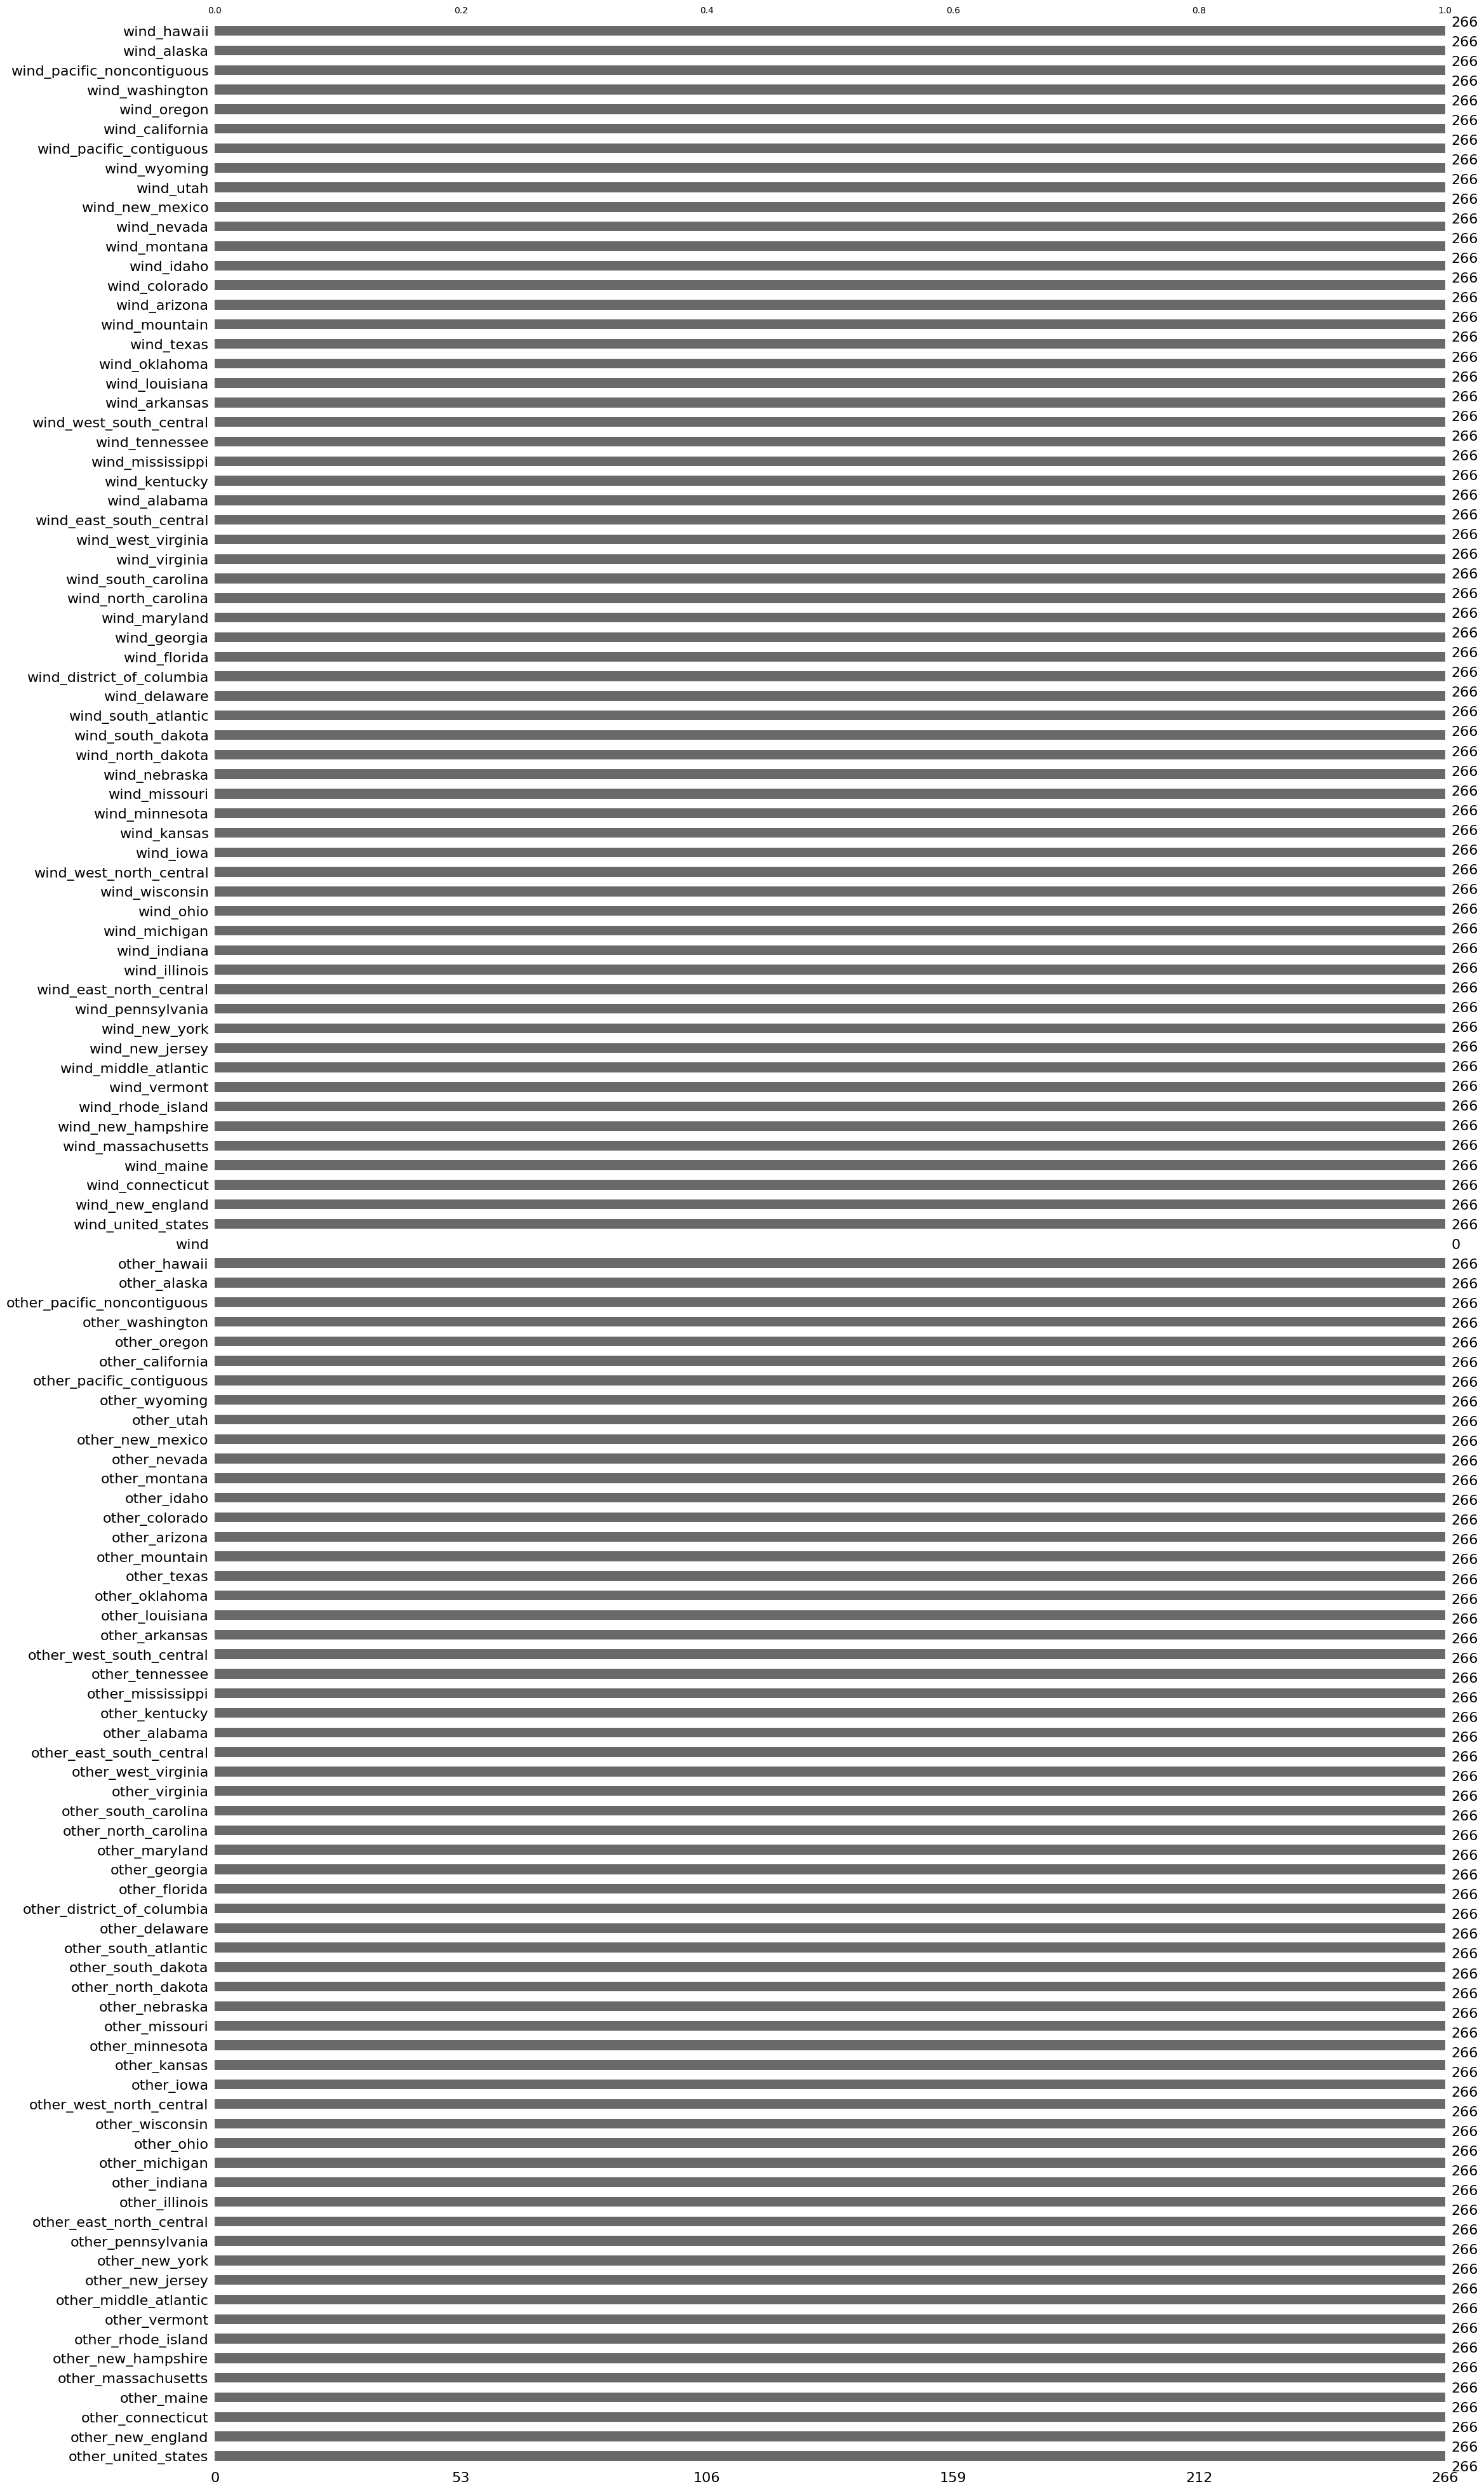

In [5]:
msno.bar(df)

At first glance, there appears to be no missing values, however we already know this isn't true after looking at the first few rows. This means that the missing values are recorded as strings and will need to be transformed into proper NumPy null values.

#### Wind
Let's focus on the wind columns as it is the only specified form of energy for this dataset.

In [6]:
wind = [col for col in df.columns if 'wind' in col]
wind_df = df[wind]

wind_df.head().style.format(precision=1).set_properties(**{'border': '1.5px solid black'}).background_gradient(cmap='binary')

,wind,wind_united_states,wind_new_england,wind_connecticut,wind_maine,wind_massachusetts,wind_new_hampshire,wind_rhode_island,wind_vermont,wind_middle_atlantic,wind_new_jersey,wind_new_york,wind_pennsylvania,wind_east_north_central,wind_illinois,wind_indiana,wind_michigan,wind_ohio,wind_wisconsin,wind_west_north_central,wind_iowa,wind_kansas,wind_minnesota,wind_missouri,wind_nebraska,wind_north_dakota,wind_south_dakota,wind_south_atlantic,wind_delaware,wind_district_of_columbia,wind_florida,wind_georgia,wind_maryland,wind_north_carolina,wind_south_carolina,wind_virginia,wind_west_virginia,wind_east_south_central,wind_alabama,wind_kentucky,wind_mississippi,wind_tennessee,wind_west_south_central,wind_arkansas,wind_louisiana,wind_oklahoma,wind_texas,wind_mountain,wind_arizona,wind_colorado,wind_idaho,wind_montana,wind_nevada,wind_new_mexico,wind_utah,wind_wyoming,wind_pacific_contiguous,wind_california,wind_oregon,wind_washington,wind_pacific_noncontiguous,wind_alaska,wind_hawaii
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,nan,389,1,--,--,--,--,--,1,3,--,2,1,4,--,--,--,--,4,130,44,--,86,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,84,--,--,--,84,30,--,4,--,--,--,--,--,26,137,133,3,--,0,0,0
2001-02-01 00:00:00,nan,431,1,--,--,--,--,--,1,2,--,1,1,4,--,--,--,--,4,106,33,--,73,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,142,--,--,--,142,25,--,2,--,--,--,--,--,23,151,148,3,--,0,0,0
2001-03-01 00:00:00,nan,532,1,--,--,--,--,--,1,3,--,2,1,3,--,--,--,--,3,105,38,--,67,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,88,--,--,--,88,24,--,2,--,--,--,--,--,22,308,300,8,--,0,0,0
2001-04-01 00:00:00,nan,685,1,--,--,--,--,--,1,3,--,2,1,5,--,--,--,--,5,146,54,--,91,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,115,--,--,--,115,16,--,3,--,--,--,--,--,13,399,393,6,--,0,0,0
2001-05-01 00:00:00,nan,635,1,--,--,--,--,--,1,3,--,2,1,4,--,--,--,--,4,122,48,--,73,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,103,--,--,--,103,19,--,3,--,--,--,--,--,16,383,378,6,--,0,0,0


For the purposes of this dataset, we are going to focus only on individual states, all other regions will be dropped.

In [7]:
columns_to_drop = [
    'wind',
    'wind_united_states',
    'wind_new_england',
    'wind_middle_atlantic',
    'wind_east_north_central',
    'wind_west_north_central',
    'wind_south_atlantic',
    'wind_district_of_columbia',
    'wind_east_south_central',
    'wind_west_south_central',
    'wind_mountain',
    'wind_pacific_contiguous',
    'wind_pacific_noncontiguous'
]

dropped_columns = [col for col in columns_to_drop if col in wind_df.columns]
wind_states_df = wind_df.drop(columns=dropped_columns)

wind_states_df.head().style.format(precision=1).set_properties(**{'border': '1.5px solid black'}).background_gradient(cmap='binary')

,wind_connecticut,wind_maine,wind_massachusetts,wind_new_hampshire,wind_rhode_island,wind_vermont,wind_new_jersey,wind_new_york,wind_pennsylvania,wind_illinois,wind_indiana,wind_michigan,wind_ohio,wind_wisconsin,wind_iowa,wind_kansas,wind_minnesota,wind_missouri,wind_nebraska,wind_north_dakota,wind_south_dakota,wind_delaware,wind_florida,wind_georgia,wind_maryland,wind_north_carolina,wind_south_carolina,wind_virginia,wind_west_virginia,wind_alabama,wind_kentucky,wind_mississippi,wind_tennessee,wind_arkansas,wind_louisiana,wind_oklahoma,wind_texas,wind_arizona,wind_colorado,wind_idaho,wind_montana,wind_nevada,wind_new_mexico,wind_utah,wind_wyoming,wind_california,wind_oregon,wind_washington,wind_alaska,wind_hawaii
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,--,--,--,--,--,1,--,2,1,--,--,--,--,4,44,--,86,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,84,--,4,--,--,--,--,--,26,133,3,--,0,0
2001-02-01 00:00:00,--,--,--,--,--,1,--,1,1,--,--,--,--,4,33,--,73,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,142,--,2,--,--,--,--,--,23,148,3,--,0,0
2001-03-01 00:00:00,--,--,--,--,--,1,--,2,1,--,--,--,--,3,38,--,67,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,88,--,2,--,--,--,--,--,22,300,8,--,0,0
2001-04-01 00:00:00,--,--,--,--,--,1,--,2,1,--,--,--,--,5,54,--,91,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,115,--,3,--,--,--,--,--,13,393,6,--,0,0
2001-05-01 00:00:00,--,--,--,--,--,1,--,2,1,--,--,--,--,4,48,--,73,--,0,--,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,103,--,3,--,--,--,--,--,16,378,6,--,0,0


Now let's take a look at the data types, these are good indicaators of how data was inserted. Given that this dataset should be entirely number based, aside from the date, all features should be either be Int64 (integers and NaN) or int64 (pure integers) in order for pandas and numpy to properly analyze them.

In [8]:
wind_states_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2001-01-01 to 2023-02-01
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   wind_connecticut     266 non-null    object
 1   wind_maine           266 non-null    object
 2   wind_massachusetts   266 non-null    object
 3   wind_new_hampshire   266 non-null    object
 4   wind_rhode_island    266 non-null    object
 5   wind_vermont         266 non-null    int64 
 6   wind_new_jersey      266 non-null    object
 7   wind_new_york        266 non-null    int64 
 8   wind_pennsylvania    266 non-null    int64 
 9   wind_illinois        266 non-null    object
 10  wind_indiana         266 non-null    object
 11  wind_michigan        266 non-null    object
 12  wind_ohio            266 non-null    object
 13  wind_wisconsin       266 non-null    int64 
 14  wind_iowa            266 non-null    int64 
 15  wind_kansas          266 non-null    o

Interesting, over half of the features are objects, this is happening due to a mix of integers and strings in the same feature. This is going to result in all of the features that have a Dtype of 'object' to have their numbers be strings, which is not what we want. To get a better understanding of this, we'll look at a column classified as an object and a column classified as an integer. Notice how the object feature is an array of strings while the int64 feature is an array of pure integers. To get some quantitative analysis, we will need to convert every feature with strings into an array of integers where missing values are properly recorded as NaN.  

In [9]:
wind_states_df.wind_connecticut.unique()

array(['--', '1', '2', '0', 'NM'], dtype=object)

It looks like there are 2 different value types for missing values, both are strings and will need to get changed to NaN to be classified as a null value. Right now pandas thinks these are strings are not missing values, so we will have some more cleaning to do. 'NM' is most likely an acronym for 'Not Measured', a common term for missing values. Remember 0 is not considered missing data as it was recorded to be 0 rather than not recorded at all. 

In [10]:
wind_states_df.wind_vermont.unique()

array([ 1,  0,  2,  5, 11, 12,  9,  8,  7,  4, 14, 13, 23, 22, 18, 20, 21,
       15, 16, 25, 31, 34, 27, 17, 32, 33, 38, 30, 29, 26, 24, 28, 39, 41,
       35, 36, 37, 42, 19, 45, 40, 43, 49], dtype=int64)

Notice that these are all integers and not strings, this most likely due to this state consistently reporting their wind energy numbers, even when they are 0. Now let's replace '--' and 'NM' with np.NaN so that pandas know it's a missing value.

In [11]:
wind_states_df.replace(['--', 'NM'], np.NaN, inplace=True)
wind_states_df.wind_connecticut.unique()

array([nan, '1', '2', '0'], dtype=object)

Good, the missing values recorded as strings are now a proper null datatype, the only thing left is to convert the numbers that are currently strings in the object type features into integers.

In [12]:
# Iterate over each column in the DataFrame
for column in wind_states_df.columns:
    # Check if the column is of object type
    if wind_states_df[column].dtype == 'object':
        # Use pd.to_numeric to convert all values to numbers, errors='coerce' will convert errors (non-convertible values) to NaN
        temp_series = pd.to_numeric(wind_states_df[column], errors='coerce')
        
        # Check if all values in the temp_series are not NaN (meaning all could be converted to numbers) 
        # and check if after dropping NaN values, the Series is not empty
        if not temp_series.isnull().all() and not temp_series.dropna().empty:
            # Convert the original column to numeric type, then to int64 if possible
            wind_states_df[column] = pd.to_numeric(wind_states_df[column], errors='coerce').astype('Int64')

Keep in mind, Int64 (capital "I") is a pandas specific nullable integer type, different from NumPy's int64 (lowercase "i"), which does not support NaN values.

In [13]:
wind_states_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2001-01-01 to 2023-02-01
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   wind_connecticut     85 non-null     Int64  
 1   wind_maine           191 non-null    Int64  
 2   wind_massachusetts   192 non-null    Int64  
 3   wind_new_hampshire   182 non-null    Int64  
 4   wind_rhode_island    158 non-null    Int64  
 5   wind_vermont         266 non-null    int64  
 6   wind_new_jersey      206 non-null    Int64  
 7   wind_new_york        266 non-null    int64  
 8   wind_pennsylvania    266 non-null    int64  
 9   wind_illinois        242 non-null    Int64  
 10  wind_indiana         178 non-null    Int64  
 11  wind_michigan        255 non-null    Int64  
 12  wind_ohio            218 non-null    Int64  
 13  wind_wisconsin       266 non-null    int64  
 14  wind_iowa            266 non-null    int64  
 15  wind_kansas          

For clarification, there are 4 datatypes here. The Int64 type represents states that have both quantifiable integers and null values within its array. The int64 type represents states that have no missing values, 0 and above. The float64 type represents states that have all missing values.

In [14]:
wind_states_df.wind_connecticut.unique()

<IntegerArray>
[<NA>, 1, 2, 0]
Length: 4, dtype: Int64

In [15]:
wind_states_df.wind_vermont.unique()

array([ 1,  0,  2,  5, 11, 12,  9,  8,  7,  4, 14, 13, 23, 22, 18, 20, 21,
       15, 16, 25, 31, 34, 27, 17, 32, 33, 38, 30, 29, 26, 24, 28, 39, 41,
       35, 36, 37, 42, 19, 45, 40, 43, 49], dtype=int64)

In [16]:
wind_states_df.wind_georgia.unique()

array([nan])

Since there are multiple states that have no data at all, we can just drop those columns as they provide no useful information to this analysis. We can only assess states that actually reported numbers and participated, even if those numbers are 0.

In [17]:
# Dropping columns where data type is float64 due to the column only containing null values
empty_states = [col for col in wind_states_df.columns if wind_states_df[col].dtype == 'float64' and wind_states_df[col].isna().all()]
wind_states_df = wind_states_df.drop(columns=empty_states)

# Note: seeing a completely black value means that pandas knows it's a null value
wind_states_df.head().style.format(precision=2).set_properties(**{'border': '1.5px solid black'}).background_gradient(cmap='binary')

,wind_connecticut,wind_maine,wind_massachusetts,wind_new_hampshire,wind_rhode_island,wind_vermont,wind_new_jersey,wind_new_york,wind_pennsylvania,wind_illinois,wind_indiana,wind_michigan,wind_ohio,wind_wisconsin,wind_iowa,wind_kansas,wind_minnesota,wind_missouri,wind_nebraska,wind_north_dakota,wind_south_dakota,wind_delaware,wind_florida,wind_maryland,wind_north_carolina,wind_virginia,wind_west_virginia,wind_tennessee,wind_oklahoma,wind_texas,wind_arizona,wind_colorado,wind_idaho,wind_montana,wind_nevada,wind_new_mexico,wind_utah,wind_wyoming,wind_california,wind_oregon,wind_washington,wind_alaska,wind_hawaii
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,,,,,,1,,2,1,,,,,4,44,,86,,0,,0,,,,,,,,,84,,4,,,,,,26,133,3,,0,0
2001-02-01 00:00:00,,,,,,1,,1,1,,,,,4,33,,73,,0,,0,,,,,,,,,142,,2,,,,,,23,148,3,,0,0
2001-03-01 00:00:00,,,,,,1,,2,1,,,,,3,38,,67,,0,,0,,,,,,,,,88,,2,,,,,,22,300,8,,0,0
2001-04-01 00:00:00,,,,,,1,,2,1,,,,,5,54,,91,,0,,0,,,,,,,,,115,,3,,,,,,13,393,6,,0,0
2001-05-01 00:00:00,,,,,,1,,2,1,,,,,4,48,,73,,0,,0,,,,,,,,,103,,3,,,,,,16,378,6,,0,0


In [18]:
print(wind_states_df.shape)
wind_states_df.info()

(266, 43)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2001-01-01 to 2023-02-01
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   wind_connecticut     85 non-null     Int64
 1   wind_maine           191 non-null    Int64
 2   wind_massachusetts   192 non-null    Int64
 3   wind_new_hampshire   182 non-null    Int64
 4   wind_rhode_island    158 non-null    Int64
 5   wind_vermont         266 non-null    int64
 6   wind_new_jersey      206 non-null    Int64
 7   wind_new_york        266 non-null    int64
 8   wind_pennsylvania    266 non-null    int64
 9   wind_illinois        242 non-null    Int64
 10  wind_indiana         178 non-null    Int64
 11  wind_michigan        255 non-null    Int64
 12  wind_ohio            218 non-null    Int64
 13  wind_wisconsin       266 non-null    int64
 14  wind_iowa            266 non-null    int64
 15  wind_kansas          255 non-null    Int64
 1

#### Now let's get a new and more accurate view of the missing data.

<Axes: >

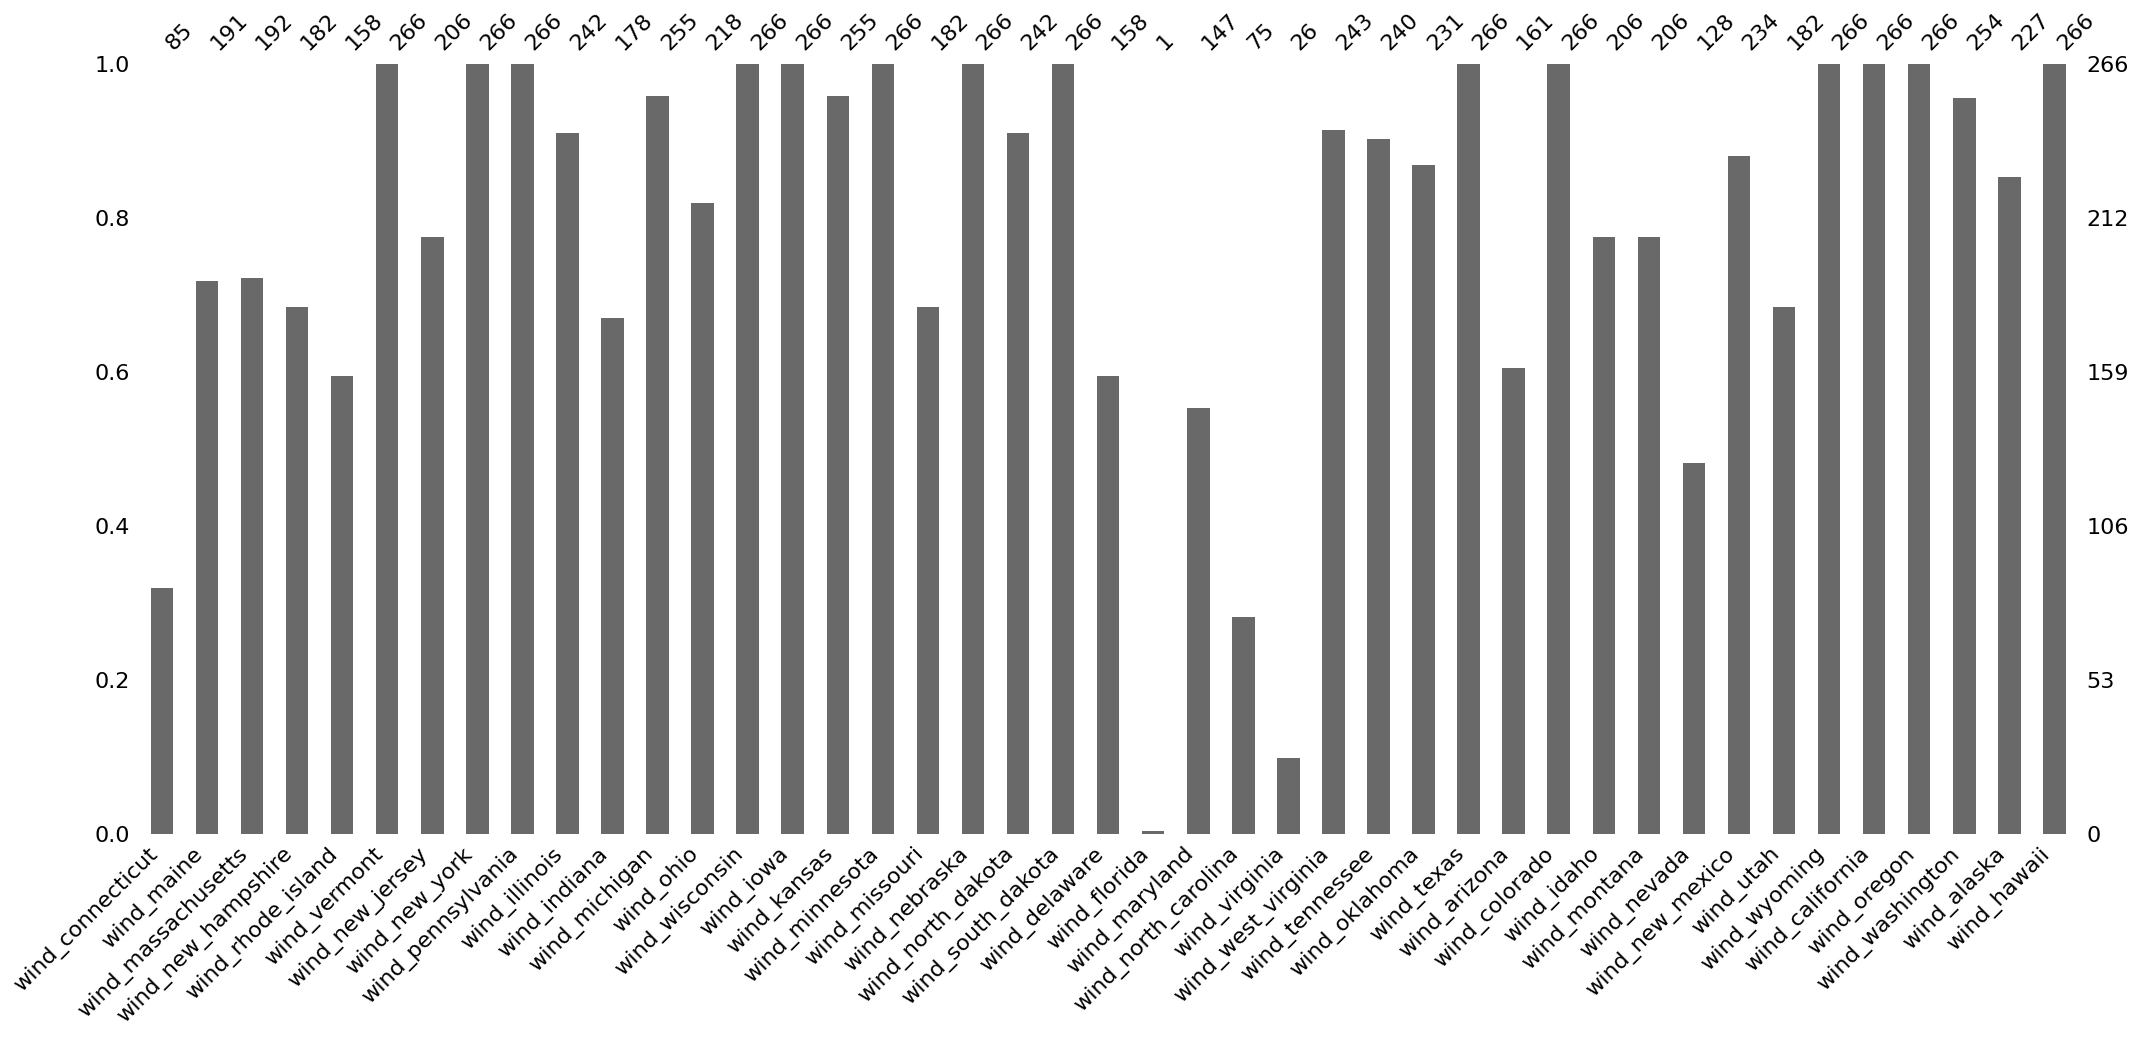

In [19]:
msno.bar(wind_states_df)

In [20]:
wind_states_df.isnull().sum()

wind_connecticut       181
wind_maine              75
wind_massachusetts      74
wind_new_hampshire      84
wind_rhode_island      108
wind_vermont             0
wind_new_jersey         60
wind_new_york            0
wind_pennsylvania        0
wind_illinois           24
wind_indiana            88
wind_michigan           11
wind_ohio               48
wind_wisconsin           0
wind_iowa                0
wind_kansas             11
wind_minnesota           0
wind_missouri           84
wind_nebraska            0
wind_north_dakota       24
wind_south_dakota        0
wind_delaware          108
wind_florida           265
wind_maryland          119
wind_north_carolina    191
wind_virginia          240
wind_west_virginia      23
wind_tennessee          26
wind_oklahoma           35
wind_texas               0
wind_arizona           105
wind_colorado            0
wind_idaho              60
wind_montana            60
wind_nevada            138
wind_new_mexico         32
wind_utah               84
w

#### Missing Value Threshold
A standard rule in data science is to drop features with around 50-60 % missing values. Since this dataset only has a limited number of rows, we will set the threshold at 60%. This means that if a column has more than 60% missing values, then we will drop them as well.

In [21]:
threshold = wind_states_df.shape[0] * 0.60
threshold

159.6

<Axes: >

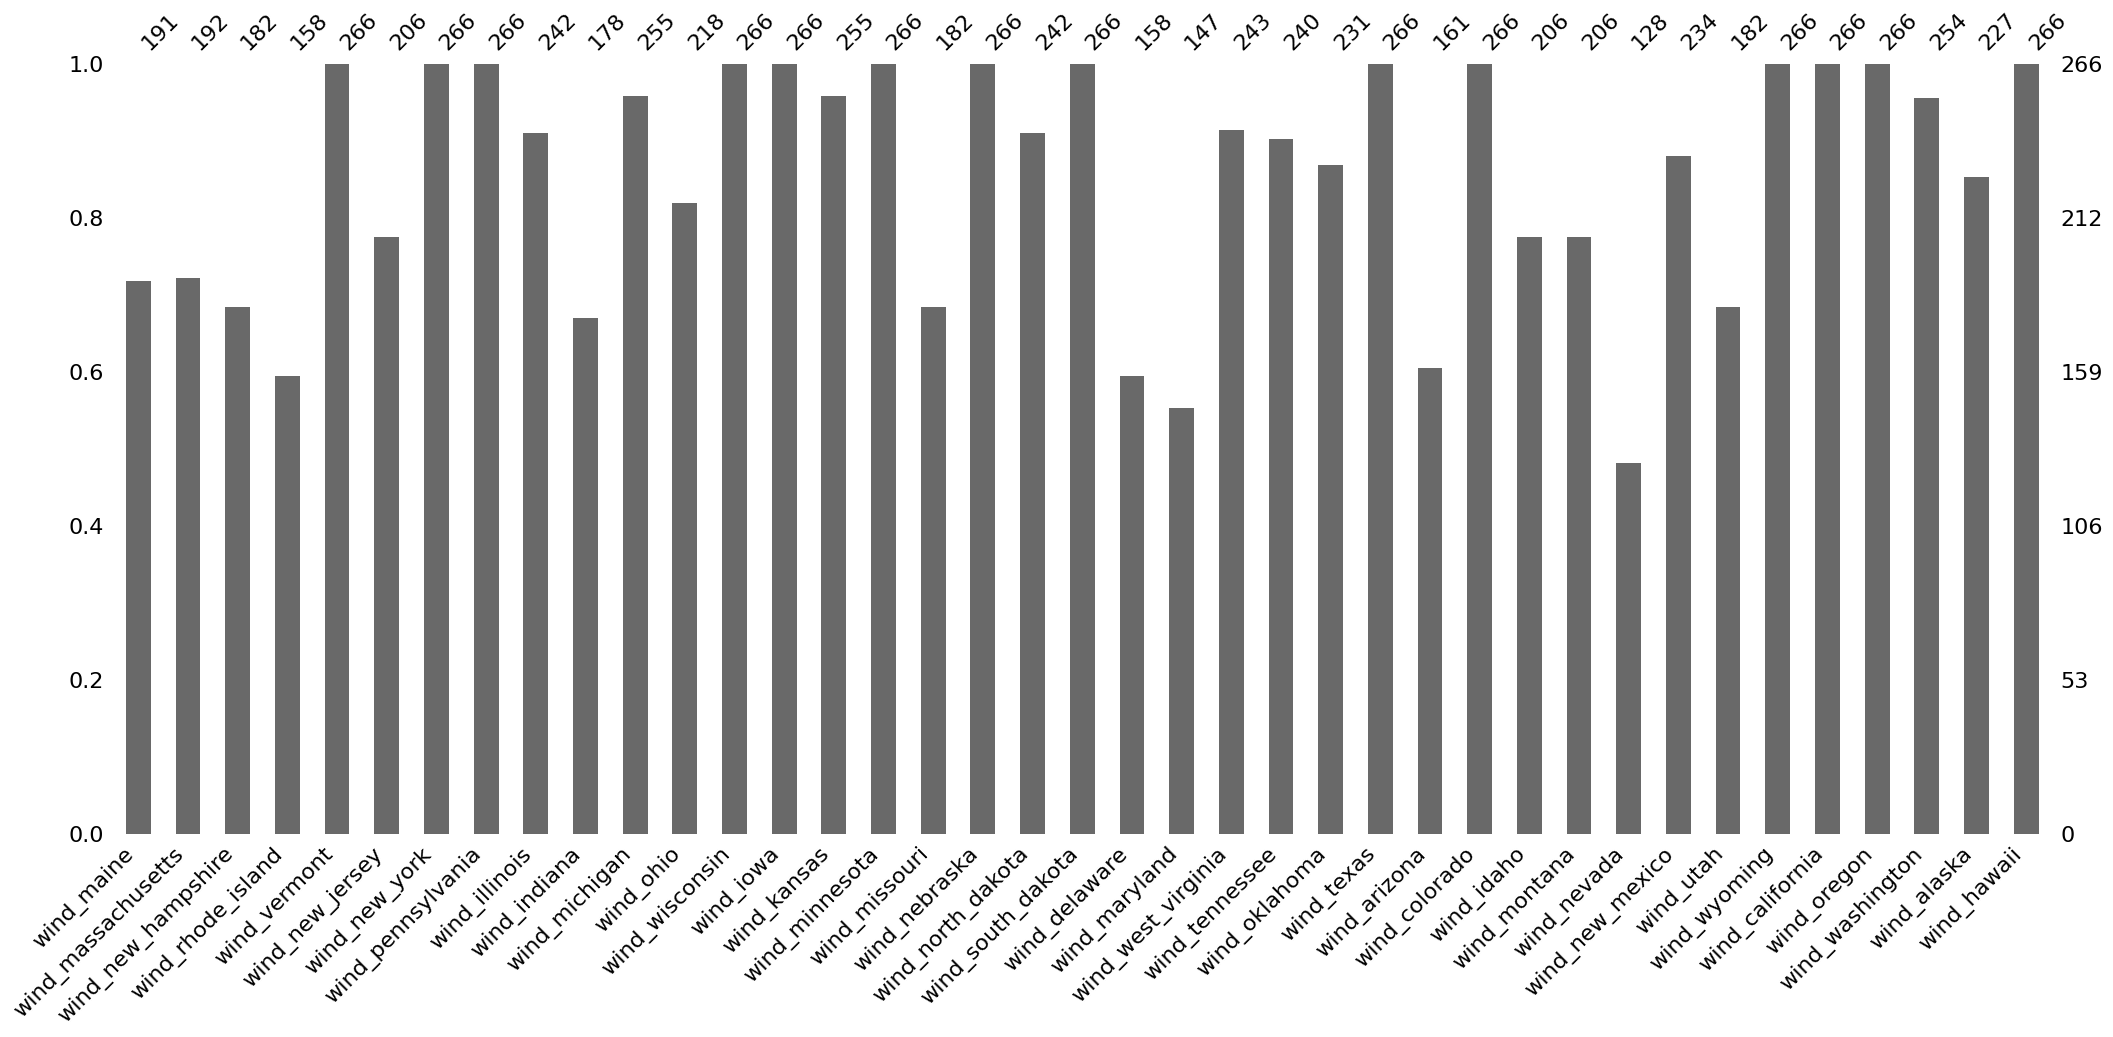

In [22]:
# If the state has missing more missing values than the threshold, it will be appended to a list
threshold_states = [column for column in wind_states_df.columns if wind_states_df[column].isnull().sum() >= threshold]

# Now to drop every state that is in this threshold list in order to only have states with missing value thresholds less than 60% 
wind_states_df = wind_states_df.drop(columns=threshold_states)
msno.bar(wind_states_df)

Now we know what we are actually working with for wind energy data.

# EDA

## Correlation Matrix

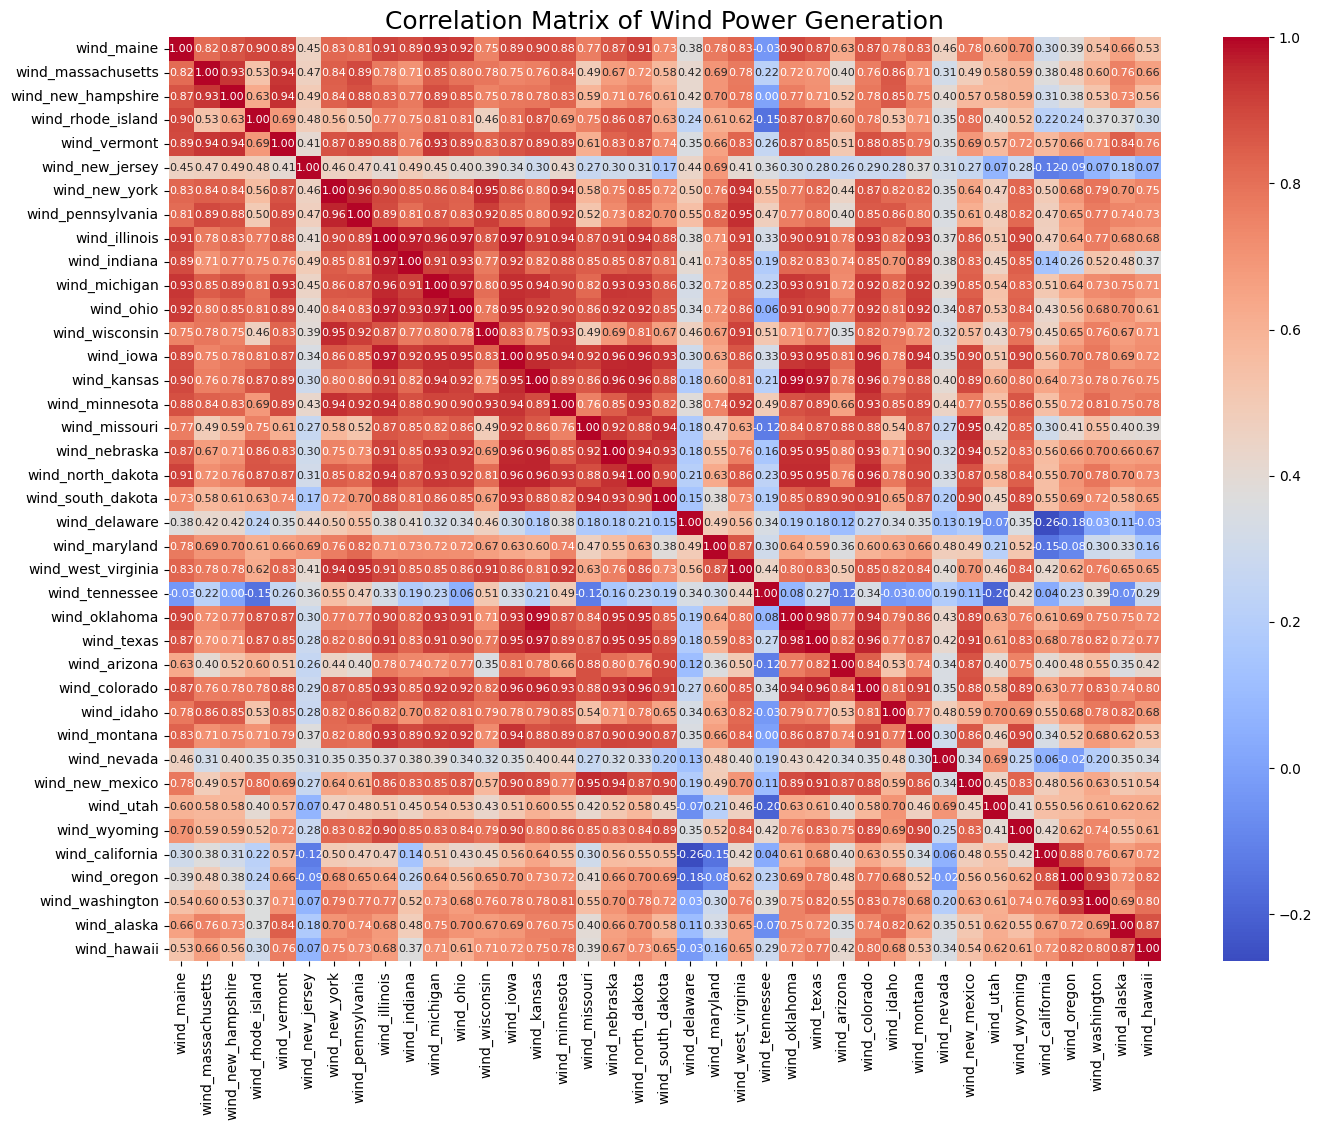

In [23]:
corr_matrix = wind_states_df.corr()

plt.figure(figsize=(16, 12))  

# Heatmap with adjusted annotation font size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})

# Setting title and tick label sizes to be more readable
plt.title('Correlation Matrix of Wind Power Generation', size=18)
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)  
plt.show()

#### Interpretation
Numbers between 0.90 and 0.99 show a very high positive correlation, meaning wind power output in one state almost always rises and falls in sync with the other. This could be due to shared climatic conditions, as neighboring states often experience similar weather patterns affecting wind strength and consistency. Additionally, regional energy policies and investments could drive development in a coordinated way, leading to simultaneous growth in wind energy production.

States with dark blue values, which are rarer, display a moderately inverse relationship. When wind energy production goes up in one of these states, it tends to go down in the other. These differences could result from geographical diversity — states with different weather systems may not experience conducive wind conditions at the same time. For instance, when seasonal weather patterns favor wind energy production in one state, they might be unfavorable in another.

Recognizing these correlations is crucial for energy planning. States with high positive correlations might not provide energy security for each other since they're likely to face production dips simultaneously. On the other hand, states with inverse relationships could potentially balance each other's energy supply, contributing to a more stable national energy grid.

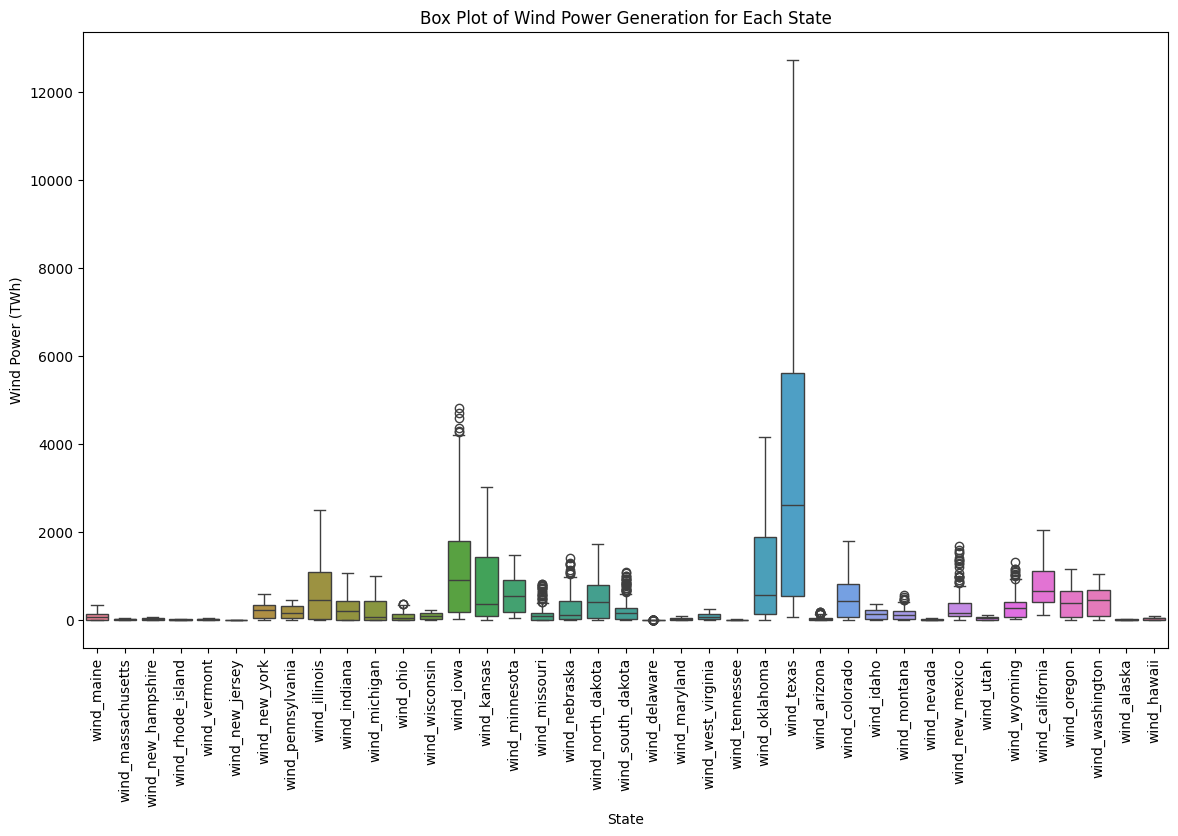

In [24]:
# Fill missing values with 0 as the boxplot does not allow missing values
wind_states_df_filled = wind_states_df.fillna(0)

plt.figure(figsize=(14, 8))
sns.boxplot(data=wind_states_df_filled)
plt.title('Box Plot of Wind Power Generation for Each State')
plt.ylabel('Wind Power (TWh)')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.show()

The boxplot clearly illustrates that Texas stands as the leading state in the United States for wind power production. Now, by examining this through a time series analysis, we'll explore how these states have been progressively increasing their annual wind power output over time.

## Top 10 Wind Energy Producers

In [25]:
# Calculate the average wind power for each state and sort them
average_wind_power = wind_states_df.mean().sort_values(ascending=False)

# Select the top 10 states based on average wind power
top_10_states = average_wind_power.head(10).index
wind_states_top_10_df = wind_states_df[top_10_states]

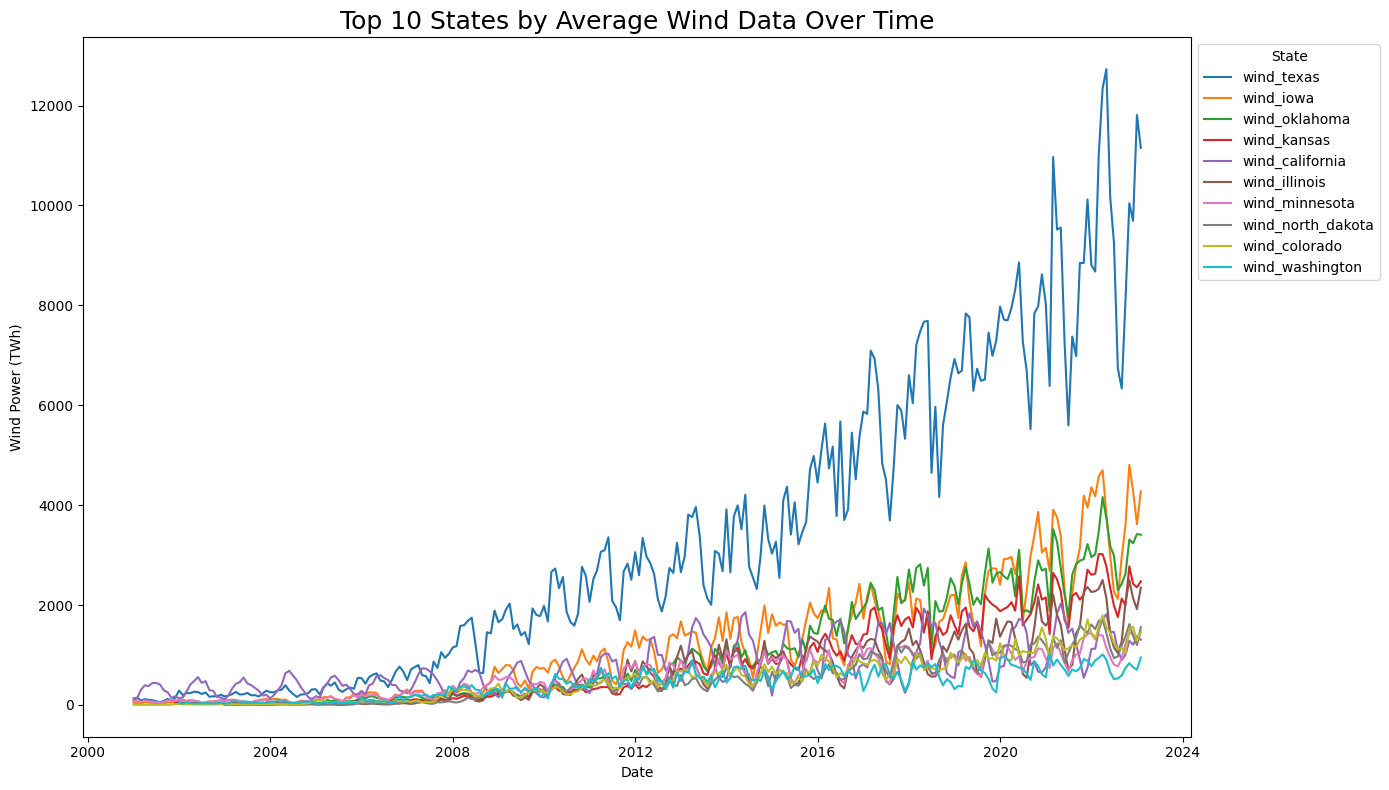

In [26]:
plt.figure(figsize=(14, 8))

# Iterate through the top 10 state list and plot each state
for column in wind_states_top_10_df.columns:
    sns.lineplot(x=wind_states_top_10_df.index, y=wind_states_top_10_df[column], label=column) 

plt.title('Top 10 States by Average Wind Data Over Time', size = 18)
plt.ylabel('Wind Power (TWh)')
plt.xlabel('Date')
plt.legend(title='State', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Texas Wind Energy Production in Perspective

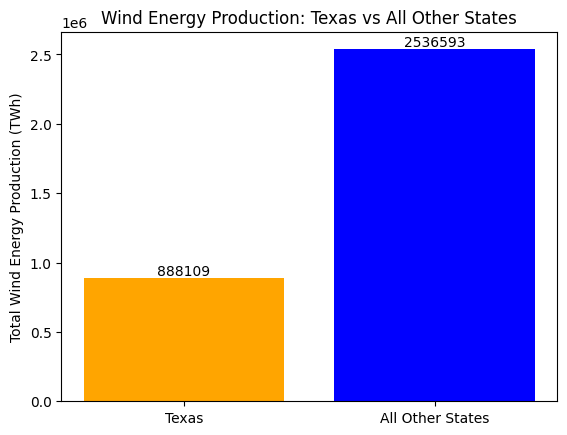

In [27]:
# Calculate the total production for Texas and the total production for all other states
texas_production = wind_states_df['wind_texas'].sum()
us_excluding_texas_production = wind_states_df.drop(columns='wind_texas').sum(axis=1).sum()
Texas_vs_US = pd.DataFrame({
    'Region': ['Texas', 'All Other States'],
    'Total Production': [texas_production, us_excluding_texas_production]
})

fig, ax = plt.subplots()
bars = ax.bar(Texas_vs_US['Region'], Texas_vs_US['Total Production'], color=['orange', 'blue'])

# Label each bar with its respective value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval), ha='center', va='bottom')
    
ax.set_ylabel('Total Wind Energy Production (TWh)')
ax.set_title('Wind Energy Production: Texas vs All Other States')
plt.show()

## National Wind Energy Production Map

In [28]:
# Plotly requires specific names or 'codes' in order to identify each state and plot them. Here
# we'll need to map each state to their respective code
state_codes = {'Maine': 'ME', 'Massachusetts': 'MA', 'New Hampshire': 'NH', 
               'Rhode Island': 'RI', 'Vermont': 'VT', 'New Jersey': 'NJ', 
               'New York': 'NY', 'Pennsylvania': 'PA', 'Illinois': 'IL', 
               'Indiana': 'IN', 'Michigan': 'MI', 'Ohio': 'OH', 'Wisconsin': 'WI', 
               'Iowa': 'IA', 'Kansas': 'KS', 'Minnesota': 'MN', 'Missouri': 'MO', 
               'Nebraska': 'NE', 'North Dakota': 'ND', 'South Dakota': 'SD', 
               'Delaware': 'DE', 'Maryland': 'MD', 'West Virginia': 'WV', 
               'Tennessee': 'TN', 'Oklahoma': 'OK', 'Texas': 'TX', 'Arizona': 'AZ', 
               'Colorado': 'CO', 'Idaho': 'ID', 'Montana': 'MT', 'Nevada': 'NV', 
               'New Mexico': 'NM', 'Utah': 'UT', 'Wyoming': 'WY', 'California': 'CA', 
               'Oregon': 'OR', 'Washington': 'WA', 'Alaska': 'AK', 'Hawaii': 'HI'}

In [29]:
# Aggregate the final cleaned dataframe by summing up all prodduction values across each state
state_production = wind_states_df.sum()

# Now to clean up the state names and map them to their respective after capitlizing codes
state_production.index = state_production.index.str.replace('wind_', '').str.replace('_', ' ').str.title()
state_production_df = pd.DataFrame({'State': state_production.index.map(state_codes), 
                                    'Total Production': state_production.values})

# Remove any rows with NaN state codes as Plotly does not accept any missing values, this will not affect
# the quality of the data as values of 0 are represented the same as null values would be on this map
state_production_df = state_production_df.dropna(subset=['State'])

# Choropleth map with final state values
fig = px.choropleth(
    state_production_df,
    locations='State', 
    locationmode='USA-states',
    color='Total Production',
    color_continuous_scale=px.colors.sequential.Blues,
    scope='usa',
    title='Wind Power Production by State in the US'
)
fig.show()

# Machine Learning

#### Forcasting Future Production Values Using ARIMA
ARIMA is known for handling seasonal dips extremely well. First we'll need to manipulate the dataframe a little in order to aggregate all the states to see a national trend.

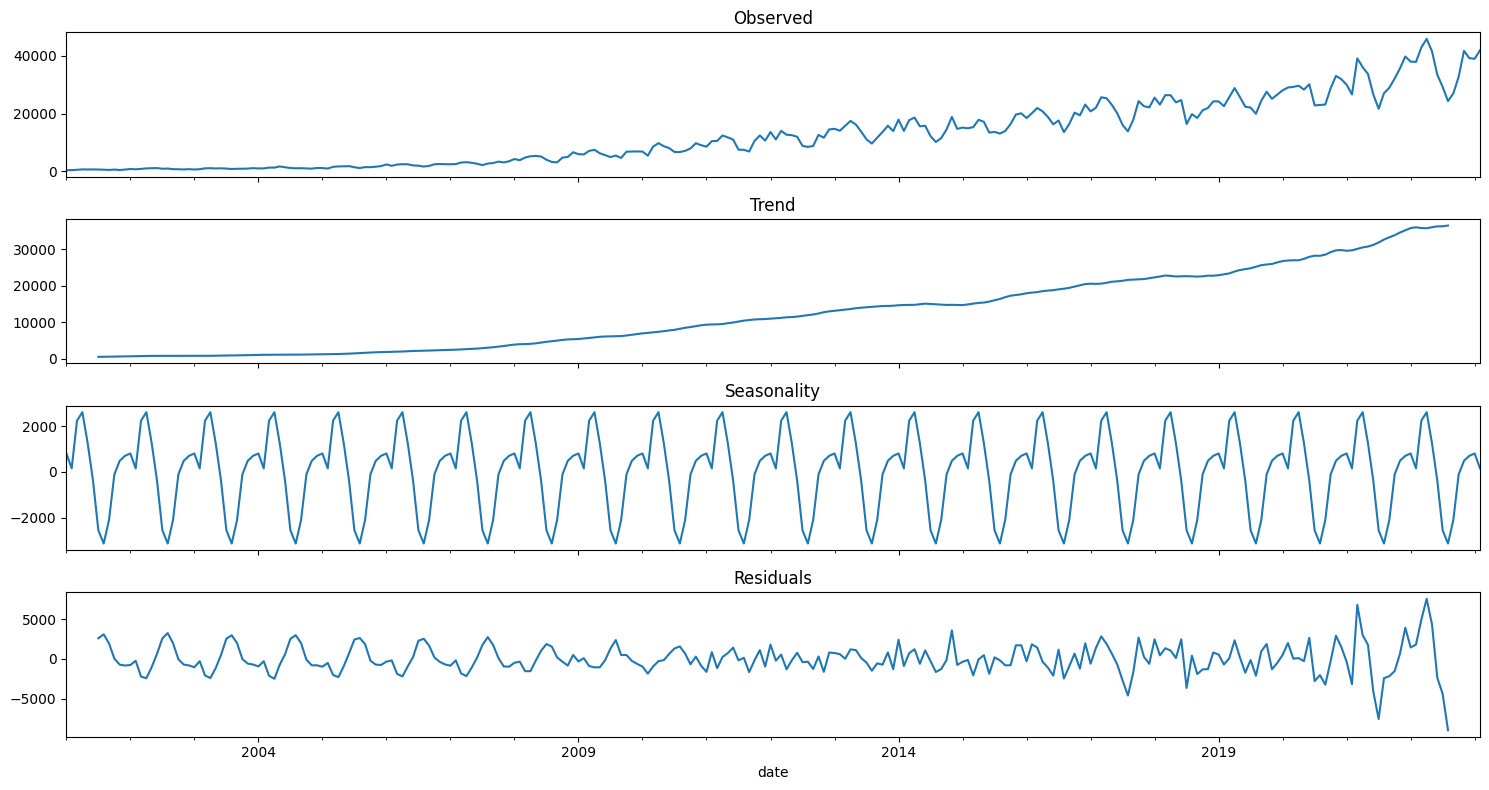

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3755.370, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3660.428, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3702.336, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3753.952, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3754.535, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3657.950, Time=0.52 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3648.867, Time=0.73 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3650.998, Time=0.38 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=3651.039, Time=0.90 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3646.510, Time=0.82 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3680.986, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3703.761, Time=0.15 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3701.918, Time=0.76 sec
 ARIMA(2,1,0)(1,0,2)[12]

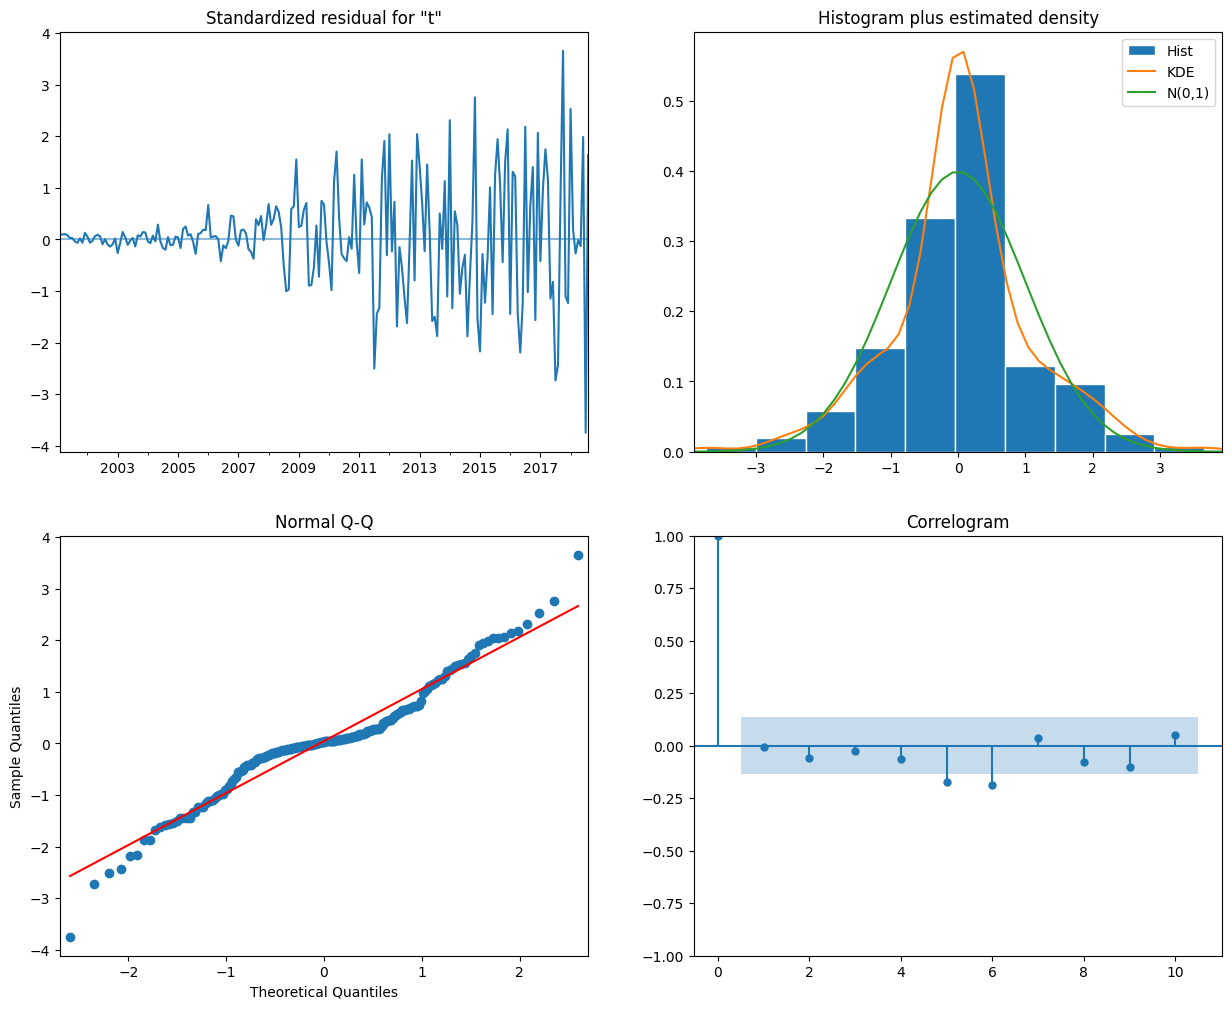

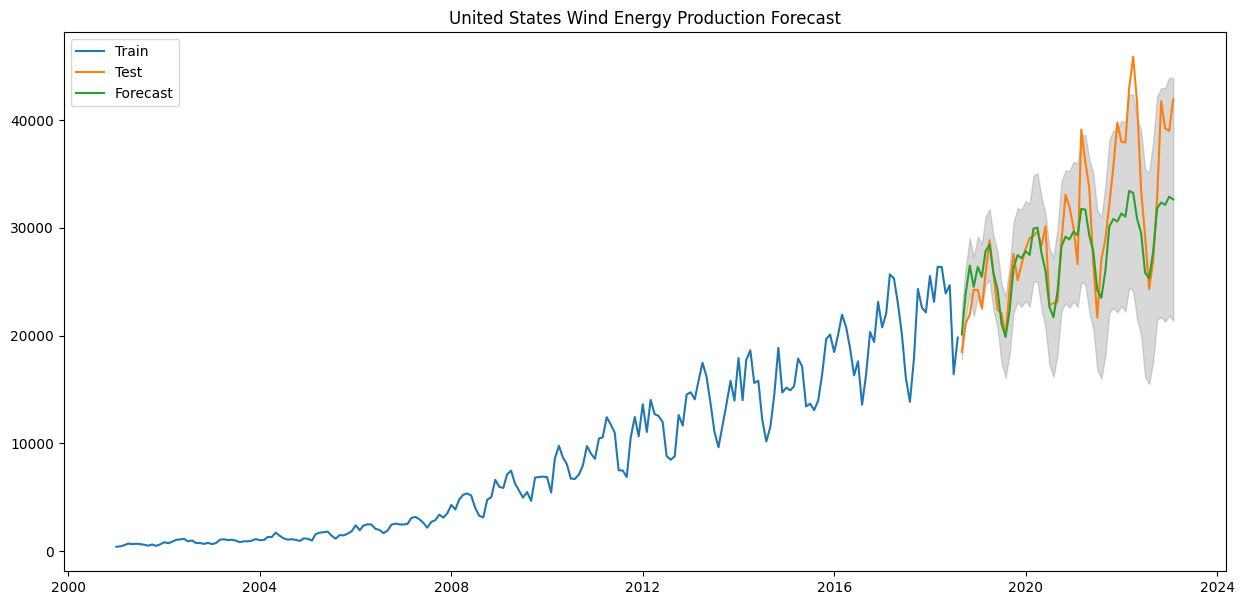

In [30]:
# Create the total US wind production column and convert it to numeric
wind_states_df['total_us'] = wind_states_df.sum(axis=1)
wind_states_df['total_us'] = pd.to_numeric(wind_states_df['total_us'], errors='coerce')

# Fill missing values using forward fill
wind_states_df['total_us'].fillna(method='ffill', inplace=True)

# Seasonal decomposition plots
decomposition = seasonal_decompose(wind_states_df['total_us'], model='additive', period=12)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8), sharex=True)
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonality')
decomposition.resid.plot(ax=ax4, title='Residuals')
plt.tight_layout()
plt.show()

# Split the data into train and test sets
total_us_series = wind_states_df['total_us']
split_point = int(len(total_us_series) * 0.8)
train, test = total_us_series[:split_point], total_us_series[split_point:]

# Use auto_arima to find the best ARIMA parameters
auto_model = auto_arima(
    train, 
    seasonal=True, 
    m=12, # 12 months in a year
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)

# Fit the ARIMA model using the best found parameters
model = ARIMA(train, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
model_fit = model.fit()

# Diagnostic plots for the ARIMA model
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast
forecasts = model_fit.get_forecast(steps=len(test))
forecast_index = test.index  
forecast_mean = forecasts.predicted_mean
forecast_conf_int = forecasts.conf_int()

# Plot the historical data, test set, and forecasts with confidence intervals
plt.figure(figsize=(15, 7))
# Training set
plt.plot(
    train.index, 
    train, 
    label='Train'
)
# Testing set, used to compare to how accurate forcast is
plt.plot(
    test.index, 
    test, 
    label='Test'
)
# Forcast
plt.plot(
    forecast_index, 
    forecast_mean, 
    label='Forecast'
)
# Concfidence interval
plt.fill_between(
    forecast_index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='grey', 
    alpha=0.3
)
plt.title("United States Wind Energy Production Forecast")
plt.legend()
plt.show()